<a href="https://colab.research.google.com/github/mollybocock/AI-Assignment-1/blob/main/MRB_Assignment3_ResNet34andLIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #3

---


### I generated local explanations for individual image predictions using LIME (Local Interpretable Model-agnostic Explanations) which was integrated with  ResNet34  - a black box model that is pretrained. It was difficult to create a model the predicted images with a high level of confidence with just 1000 samples, but a larger sample size would cost more time.
### Molly Bocock

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mollybocock/AI-Assignment-1/blob/main/MRB_Assignment3_ResNet34andLIME.ipynb)





First, we will install the necessary libraries. In addition to numpy and pandas, we will use the following libraries:


*   scikit-learn (Model, ICE plots)
*   shap (SHAP)
*   lime (LIME)
*   anchor-exp (Anchors)

source:

# XAI CODE DEMO

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/explainable-ml-example-notebooks/local_explanations.ipynb)



In [ ]:
!pip install numpy==1.25.2 pandas==2.0.3 matplotlib==3.7.1 scikit-learn==1.2.2 lime==0.2.0.1 anchor-exp==0.0.2.0 shap==0.45.1

In [ ]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

'''# Models
import xgboost
from sklearn.model_selection import train_test_split
'''

# XAI
import shap
import lime
from anchor import anchor_tabular
from sklearn.inspection import PartialDependenceDisplay

np.random.seed(1)

#Visualization of Different Layers ResNet34

I knew that I wanted to use LIME and decided that I wanted to work with images, and Claude Sonnet 3.0 recommended I use ResNet34. I wanted to get a visual to understand what the images actually looked like, becuase I was confused how to pick my area of interest - I couldn't picture it. Claude Sonnet 3.0 gave me code that uses a ResNet34 model that has been trained on ImageNet and is accessed through a library called TorchVision. This means that we get weights that were pre-trained on image net.

I asked Claude to generate code that would help me visualize different layers of ResNet34 are detecting as an image passes through the network. This is wherre I perhaps re-learned about hooks. Hooks let us see what's happening inside the network as the image data flows through it - Claude likened it to spy cameras attached within each layer of ResNet34 which was helpful. The hooks placed at each layer show different things:
In our code, we're placing hooks at three strategic locations:

Early layer (model.layer1[0].conv1): This shows us basic features like edges and basic shapes
Middle layer (model.layer2[0].conv1): This captures more complex patterns and combinations
Late layer (model.layer3[0].conv1): This shows higher-level features like specific object parts

Source: Claude Sonnet 3.0

Loading ResNet34 model...
Creating hooks...
Created 3 hooks successfully
Loading and preparing image from /content/bird.jpg...
Performing forward pass...
Creating visualization...
Processing early layer...
Processing middle layer...
Processing late layer...


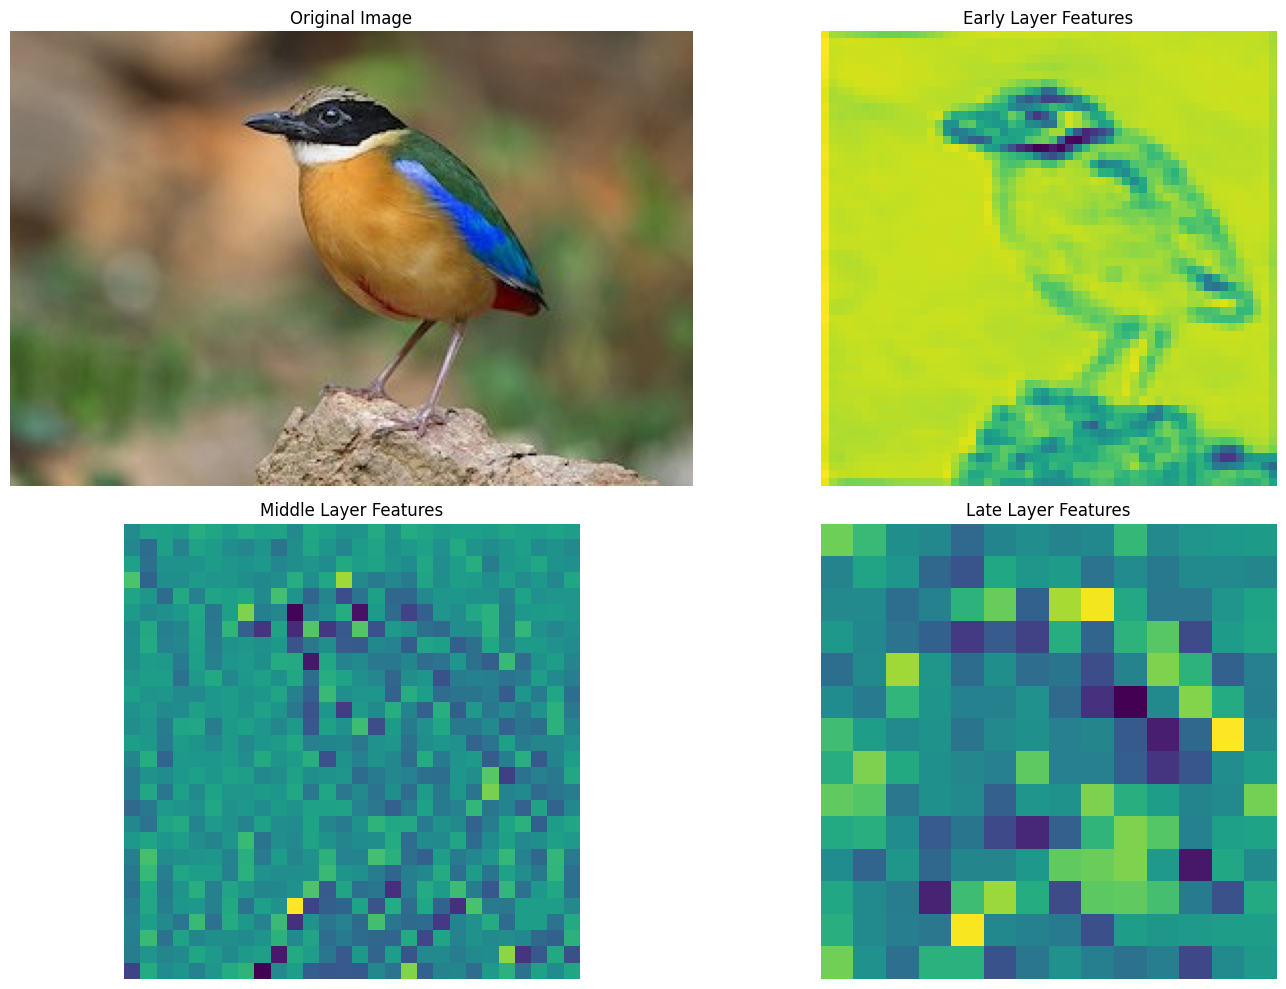

Visualization complete!
Cleaning up hooks...


In [ ]:
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

class FeatureMapHook():
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        self.features = output.detach()

    def remove(self):
        self.hook.remove()

def visualize_feature_maps(image_path, num_features=5):
    try:
        # Load pre-trained ResNet34
        print("Loading ResNet34 model...")
        model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        model.eval()

        # Create hooks for different layers
        print("Creating hooks...")
        layers = {
            'early': model.layer1[0].conv1,    # Early layer
            'middle': model.layer2[0].conv1,   # Middle layer
            'late': model.layer3[0].conv1      # Later layer
        }

        hooks = {name: FeatureMapHook(layer) for name, layer in layers.items()}
        print(f"Created {len(hooks)} hooks successfully")

        # Prepare image
        print(f"Loading and preparing image from {image_path}...")
        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Load and process image
        try:
            img = Image.open(image_path)
            img_tensor = transform(img).unsqueeze(0)
        except Exception as e:
            raise Exception(f"Error loading image: {str(e)}")

        # Forward pass
        print("Performing forward pass...")
        with torch.no_grad():
            _ = model(img_tensor)

        # Create visualization
        print("Creating visualization...")
        plt.figure(figsize=(15, 10))

        # Show original image
        plt.subplot(2, 2, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        # Show feature maps from different layers
        for idx, (name, hook) in enumerate(hooks.items(), 2):
            print(f"Processing {name} layer...")
            # Get feature maps
            features = hook.features[0]  # Remove batch dimension

            # Select random feature maps
            if features.shape[0] > num_features:
                indices = np.random.choice(features.shape[0], num_features, replace=False)
                selected_features = features[indices]
            else:
                selected_features = features

            # Create average activation map
            activation_map = torch.mean(selected_features, dim=0)

            # Normalize for visualization
            activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())

            plt.subplot(2, 2, idx)
            plt.imshow(activation_map.cpu().numpy(), cmap='viridis')
            plt.title(f'{name.capitalize()} Layer Features')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        print("Visualization complete!")

        # Clean up
        print("Cleaning up hooks...")
        for hook in hooks.values():
            hook.remove()

    except Exception as e:
        # If hooks was created, clean it up even if an error occurred
        if 'hooks' in locals():
            for hook in hooks.values():
                hook.remove()
        raise Exception(f"Error in visualization process: {str(e)}")

# Example usage:
try:
    visualize_feature_maps('/content/bird.jpg')
except Exception as e:
    print(f"Error: {str(e)}")

#ResNet34 Prediction of Output

Now that I have a better idea about how ResNet34 proceses an image, I wanted to see what it would actually be predicting as its output. The code below is the final output of ResNet34 showing its predicitions and classifications. This shows me the final output and gives me an image classification - a bar chart of the top 5 most likely classifications. It is interesting to compare HOW the network sees the image (the above code, which shows intermediate layers' feature maps) vs. WHAT the network thinks the image is (final classificatin results) Source: Claude Sonnet 3.0

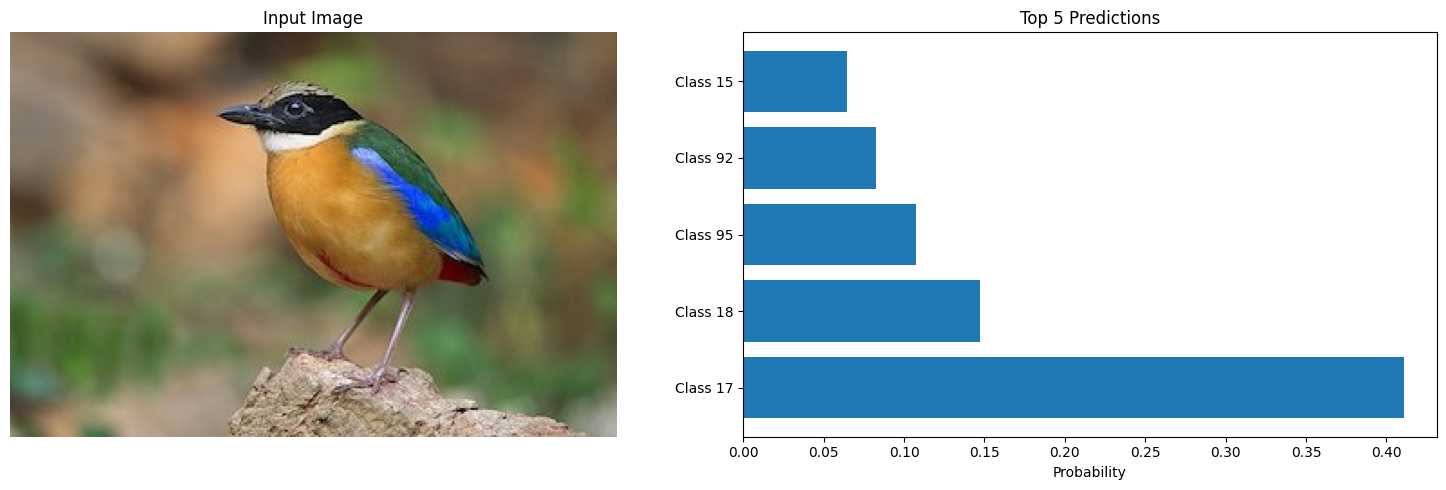


Detailed predictions:
1. Class 17: 41.08%
2. Class 18: 14.72%
3. Class 95: 10.75%
4. Class 92: 8.26%
5. Class 15: 6.46%


In [ ]:
# First, import all necessary libraries
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load pre-trained ResNet34 model
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()  # Set to evaluation mode

# Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet34 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Standard ImageNet normalization
        std=[0.229, 0.224, 0.225]
    )
])

def predict_image(img):
    """Make prediction on a single image"""
    # Convert image to tensor and add batch dimension
    img_tensor = preprocess(img).unsqueeze(0)

    # Get model predictions
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Get top 5 predictions
    top_probs, top_indices = torch.topk(probabilities, 5)

    return [(idx.item(), prob.item()) for prob, idx in zip(top_probs, top_indices)]

def classify_bird(image_path):
    """Analyze a bird image using ResNet34 and show top predictions"""
    # Load and show image
    img = Image.open(image_path).convert('RGB')
    predictions = predict_image(img)

    # Create figure for visualization
    plt.figure(figsize=(15, 5))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')

    # Show prediction probabilities
    plt.subplot(1, 2, 2)
    classes = [p[0] for p in predictions]
    probs = [p[1] for p in predictions]

    plt.barh(range(len(predictions)), probs)
    plt.yticks(range(len(predictions)), [f"Class {c}" for c in classes])
    plt.xlabel("Probability")
    plt.title("Top 5 Predictions")

    plt.tight_layout()
    plt.show()

    # Print detailed predictions
    print("\nDetailed predictions:")
    for idx, (class_id, prob) in enumerate(predictions, 1):
        print(f"{idx}. Class {class_id}: {prob:.2%}")

# Now use the model to classify your bird image
classify_bird('bird.jpg')

Understanding what I am seeing above:
In this case, ResNet34 was pre-trained on ImageNet and uses both PyTorch and TorchVision for classification. ResNet34 is a deep neural network with 34 layers, has been pre-trained on ImageNet (a huge dataset of ~1.2 million images). PyTorch and TorchVision work together:  PyTorch handles the core deep learning operations, while TorchVision provides the pre-trained model and image processing tools. So I uploaded a picture of a bird and fed it to this model, it does its magic, and spit out 5 predictions of what it thinks the image is and includes the confidence level. Here the model is most confident the image is Class 17. The image needed to be resized to 224x224 pixels noramlized before it made predictions.
source: Combination of me and Claude Sonnet 3.0
Bird photo taken from Wikimedia Commons

Now for the actual assignment - Generate local explanations for individual predictions from ResNet34 using LIME. In this case I am using an image of a cat (from Wikimedia Commons). This code was generated with Claude Sonnet 3.0

#Generate Local Explanations for Individual Predictions From ResNet34 Using LIME

Download successful
Image loaded successfully

Prediction: tiger cat
Confidence: 53.26%

Generating LIME explanation...


  0%|          | 0/1000 [00:00<?, ?it/s]

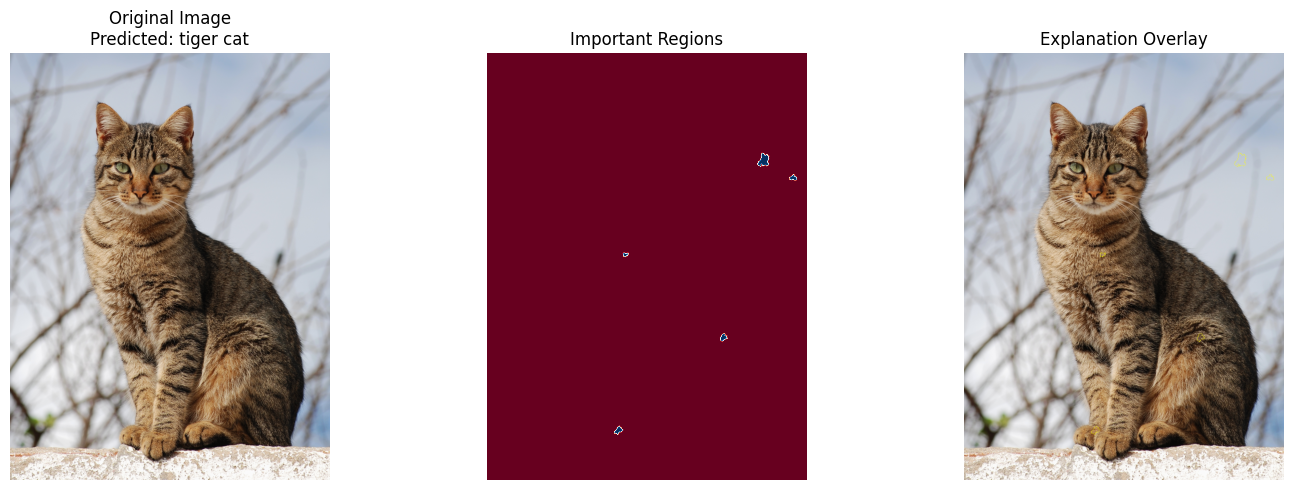

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import json

def download_image(url):
    """Download image from URL with error handling"""
    try:
        print(f"Downloading image from {url}")
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        print("Download successful")
        return Image.open(BytesIO(response.content)).convert('RGB')
    except Exception as e:
        print(f"Error downloading image: {str(e)}")
        return None

def explain_image_from_url(image_url):
    """Generate LIME explanation for an image from URL"""
    # Load image
    img = download_image(image_url)
    if img is None:
        print("Failed to load image. Exiting.")
        return

    print("Image loaded successfully")

    # Load model if not already loaded
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.eval()

    # Image preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Get initial prediction
    img_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)

    # Get class labels
    response = requests.get("https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json")
    CLASS_LABELS = json.loads(response.text)

    # Get top prediction
    top_prob, top_class = torch.max(probs, 0)
    pred_class = CLASS_LABELS[top_class]

    print(f"\nPrediction: {pred_class}")
    print(f"Confidence: {top_prob.item():.2%}")

    # Function for LIME to use
    def batch_predict(images):
        batch = torch.stack([preprocess(Image.fromarray(img)) for img in images])
        with torch.no_grad():
            output = model(batch)
            probs = torch.nn.functional.softmax(output, dim=1)
        return probs.numpy()

    # Initialize LIME explainer
    print("\nGenerating LIME explanation...")
    explainer = lime_image.LimeImageExplainer()

    # Get explanation
    explanation = explainer.explain_instance(
        np.array(img),
        batch_predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    # Visualization
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(131)
    plt.imshow(img)
    plt.title(f'Original Image\nPredicted: {pred_class}')
    plt.axis('off')

    # Explanation mask
    plt.subplot(132)
    plt.imshow(mask, cmap='RdBu')
    plt.title('Important Regions')
    plt.axis('off')

    # Overlay
    plt.subplot(133)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('Explanation Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Let's try with a reliable image URL
cat_url = "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg"
explain_image_from_url(cat_url)

#Interpretation

Interpretation
I wanted to work in images becuase I thought they would be the most hepful in literally visualizing what the model was doing. According to Claude 3.5 Sonnet (01/29/25 @10:24 pm) ResNet34 has a good architecture that is advantageous for image classification consisting of:
1.ResNet34 uses "skip connections" or "residual connections" that help solve the vanishing gradient problem in deep networks
2. At 34 layers deep, it's complex enough to learn sophisticated features but not so deep that it becomes computationally unwieldy
3. The residual connections allow it to learn both simple and complex features without degradation in performance

Furthermore, ResNet34 has been trained on ImageNet, which is an impressive dataset of millions of images. It is well-documented and used widely.

This model predicts that the image is a tiger cat with 53.26% confidence. 53.26% confidence is not very high, which is a major limitation of this model. It seems like the model is confused - it must be seeing features that belong to other types of cats and it is unsure. What happened here is I wanted to understand how ResNet34, a black box model, decides if a picture of a cat is a "tiger cat." The machine looks at the picture and says it is ~53% confident this is a tiger cat. LIME, like a detective or someone playing hide-and-go-seek, covers up different parts of the image 1,000 times and obvserves changes in the machines confidence. If hiding a certain part of the image makes the model more confident the picture is a tiger cat, that part of the picture is identified as being important to the machine's decision. In this particular case LIME identified that a few spots (the blue ones on the image with the red background) were important to the machine's decision. But there are not many of these dots, meaning there aren't many strong clear areas the machine is focused on so it is seeing some tiger cat features but is not very sure.

Limitations: It is potentially a good sign the model is not very confident/convinced. I searched images on Firefox of a "tiger cat" and didn't think they looked like this cat almost at all. I then did a Google reverse image search using the Original Image Predicted: tiger cat image and Google's search results came back saying the cat was a tabby. So it may not have been a very good picture to train the model on in the first place. So the number of samples and computational time as well as accuracy is a limitation.

I think that increasing the number of samples could help the model. Changing the kernels could also produce interesting results. I still dont know enough about kernels, so I asked Claude Sonnet 3.5 how chaning the kernels could improve the LIME model and got:

    Using different distance metrics (e.g., switching from exponential to RBF kernel) to better capture the local behavior around your instance of interest
    Adjusting kernel width parameters to control how quickly the weights decay with distance, helping balance between too local (overfit) and too global (underfit) explanations
    Implementing custom kernels that might be more appropriate for your specific data type or domain ((01/29/25 @23:13 pm)



That model was really interesting, but it was essentially built by Claude Sonnet 3.5. I decided attempt to build a model myself. To do this I usded Claude Sonnet 3.5 and a resource recommended by the TA's (thanks) https://lime-ml.readthedocs.io/_/downloads/en/latest/pdf/
I was not successful in building it myself, I still used Claude 3.5 as a resource, but I did learn a fair amount about the model. This way I was able to go back and ask questions to Claude about the first model and understand it better.

#Explained Model: Local Explanations for Individual Predictions From ResNet34 Using LIME

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import json

# 1. First, we set up our model and image
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()
#this used to be pretrained=True but it needed to change to weights
#source: ChatGPT at 8:33 pm 01/29/25

# 2.1 Define the image preprocessing transformations
preprocess = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Resize((224, 224)),  # Resize image to 224x224 (ResNet expects this size)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# 2.2 Load and prepare image
img = Image.open('zackie.JPG')
img_array = np.array(img)
#LIME expects input images as NumPy arrays. img is a PIL Image object (created from Image.open('zackie.JPG')np.array() converts it into a NumPy array

# 3. Define prediction function
def predict_fn(images):
    # Convert images to format ResNet expects
    # LIME expects input images as NumPy arrays. img is a PIL Image object (created from Image.open('zackie.JPG')np.array() converts it into a NumPy array
    batch = torch.stack([preprocess(Image.fromarray(image.copy())) for image in images])
    with torch.no_grad():
        predictions = torch.softmax(model(batch), dim=1)
    return predictions.numpy()

#torch.nograd is being used because we are only doing inference predictions, not training
#which saves memory and helps things run more quickly

# 4. Create the LIME explainer (detective's toolbox)
explainer = lime_image.LimeImageExplainer(
    kernel_width=0.25,
    verbose=False
)

#LIME explainer:
#A class is like a blueprint or template for creating objects
#In this case, LimeImageExplainer is the class - it's the template for creating an explainer object
#Think of it like a cookie cutter - it defines the basic shape and structure all instances will have source: Claude Sonnet 3.0

#The kernel and verbose part of this are the "parameters."
# Parameters are the specific values or settings you pass when creating an instance of a class
#They customize how your specific instance of the class will behave
#Using the cookie analogy, parameters would be like choosing the type of dough, frosting color, or decorations for your specific cookies

#we only have the kernel_width and verbose=False because in Python when you create an
#instance of a class you dont need to change things unless you are changing the default values
#other important parameters of LIME image explainer's class are
    #kernel_width=0.25,      # How quickly influence drops off with distance
    #kernel=None,            # The kernel function to use (default is exponential kernel)
    #verbose=False,          # Whether to print details during explanation

#kernel value:
#this is a lower value. Which means that Only very similar perturbations strongly influence the explanation.
#It also means Sharp drop-off in influence as perturbations get more different
#kernel_width=0.25 (default)
#The kernel_width=0.25 setting tells LIME how to weight these different perturbations:
#Perturbation with 2 changes: Strong influence
#Perturbation with 4 changes: Weak influence
#Perturbation with 6 changes: Very weak influence

#I didn't understand what these "changes" meant. So I asked Claude, which gave me the response:
#When LIME is understanding how a model makes decisions, it creates variations of the input image by dividing it into small segments
#(like a grid) and randomly turning some segments "off" (usually by replacing them with a neutral color or noise).
#These are the "changes" or "perturbations" being referred to.
#2 changes might mean turning off two segments of the image - maybe hiding part of the ear and part of the nose
#4 changes would hide four segments - maybe parts of the ear, nose, tail, and paw
#6 changes would hide six different segments

#a good way to think of it:
#LIME: "What if I hide the cat's ears? Let me ask predict_fn"
#predict_fn: "With ears hidden, I'm 70% sure it's a cat"
#LIME: "What if I hide the tail? Let me ask predict_fn again"
#predict_fn: "With tail hidden, I'm 85% sure it's a cat"

#When only 2 segments are changed, the model's prediction on this slightly modified image
#is considered very important for understanding how the model thinks
#When 4 segments are changed, the model's prediction on this more modified image is considered less important
#When 6 segments are changed, the prediction is considered much less important because the image is too different from the original
#Source: Claude Sonnet 3.0

#this reminds me of the erasing Daffy Duck skit where the animator keeps erasing different parts of daffy
#basically getting to the basic question of how much of Daffy Duck can you take away before he becomes unrecognizable?
#: https://www.youtube.com/watch?v=6XvXsuSJ-1A

5. #First, define the batch prediction function
def batch_predict(images):
    """
    Function that LIME uses to make predictions on perturbed images
    Args:
        images: Batch of images to predict on
    Returns:
        Probability predictions for each image
    """
    # Convert images to PyTorch tensors and preprocess
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images])

    # Make predictions
    with torch.no_grad():
        output = model(batch)
        # Convert to probabilities
        probs = torch.nn.functional.softmax(output, dim=1)

    return probs.numpy()

# 6. Get prediction for original image
prediction = batch_predict([img_array])[0]  # Use batch_predict here instead of predict_fn



# 7. Run LIME explanation (the investigation)
explanation = explainer.explain_instance(
    img_array,
    batch_predict,  # Use the batch_predict function here
    top_labels=5,
    hide_color=None,
    num_samples=1000
)
#the "explanation = explainer.explain_instance" is where the key interpretable model is created.
#Takes your image (img_array)
#Creates 1000 perturbed versions of it (num_samples=1000)
#Uses your batch_predict function to see how the model's predictions change for each perturbation
#Builds a simpler, interpretable linear model that approximates how your complex ResNet34 behaves around this specific image
#The explanation object that's returned contains this local interpretable model.
#Source: Claude Sonnet 3.5 01/29/10:37 pm

#The batch_predict function is crucial here:
#it's how LIME investigates and understands your model's behavior.
#In this case it Takes the cat image
#Creates variations (maybe hiding different parts of the cat)
#Uses batch_predict to see if hiding the stripes makes the model less confident it's a tiger cat
#Uses batch_predict to see if hiding the background changes anything
#Does this hundreds of times (num_samples=1000)
#Source: Claude Sonnet 3.5 01/29/10:38 pm

#explaining explain instance:
#perturbations happen within lime in explain_instance

#Inside explain_instance, LIME:
#First segments your image into superpixels (like puzzle pieces)
#Then creates perturbed samples by randomly turning these superpixels on/off
#inside of explain_instance is data_labels() which is actually an internal method that gets called INSIDE explain_instance()
#LimeImageExplainer
#    └── explain_instance()
#        └── data_labels()  # Called internally

#the data_labels are inside of the explainer. So the data_labels:
#(image, fudged_image, segments, classifier_fn, num_samples, batch_size=10,
#progress_bar=True) and explain_instance(image, classifier_fn, labels=(1, ), hide_color=None, top_labels=5,
#num_features=100000, num_samples=1000, batch_size=10, segmentation_fn=None, distance_metric='cosine',
#model_regressor=None, random_seed=None, progress_bar=True) are inside of the LIME explainer.

#Here is an example of what is actually happening with the data labels:
## If you have an image of a cat:
# Original segments might be: [ear, nose, whiskers, body, tail]

# data_labels() might create samples like:
#Sample 1: [1, 0, 1, 0, 0]  # Show ear and whiskers only
#Sample 2: [0, 1, 1, 1, 0]  # Show nose, whiskers, and body
#Sample 3: [1, 1, 0, 0, 1]  # Show ear, nose, and tail
# etc...

# Then gets predictions for each sample:
#Prediction 1: 0.3 probability of cat  # Hard to tell with just ear and whiskers
#Prediction 2: 0.8 probability of cat  # Easier with nose, whiskers, body
#Prediction 3: 0.4 probability of cat  # Moderate confidence with those parts

# 7. Visualize results
img, mask = explanation.get_image_and_mask(
    label=prediction.argmax(),  # Most likely class
    positive_only=True,         # Show what supported this prediction
    num_features=5,            # Show top 5 important regions
    hide_rest=False            # Show full image
)

# 8. Display the visualization
plt.figure(figsize=(10, 5))
plt.imshow(mark_boundaries(img, mask))
plt.axis('off')
plt.title('LIME Explanation')
plt.show()
#source: https://claude.site/artifacts/218bbdfe-3b52-45aa-9616-9dba805425ba

  0%|          | 0/1000 [00:00<?, ?it/s]